# Time Series Forecasting with Yahoo Stock Price

Kaggle Data: [source](https://www.kaggle.com/datasets/arashnic/time-series-forecasting-with-yahoo-stock-price)


## Explore


In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning Models
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [218]:
df = pd.read_csv('./data/yahoo_stock.csv')

In [219]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [221]:
# convert the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Adj Close           float64
dtype: object

In [222]:
# View a small portion of the dataset
df = df.set_index('Date')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


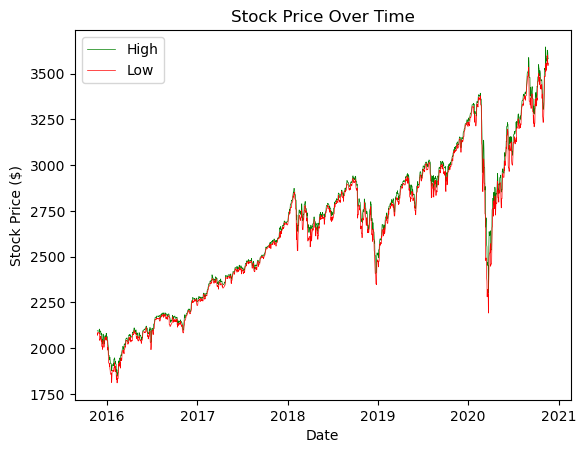

In [223]:
# Visualize high and low daily stock price
plt.plot(df.index, df['High'], linewidth=0.5, color="green", label="High")
plt.plot(df.index, df['Low'], linewidth=0.5, color="red", label="Low")
plt.title("Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()

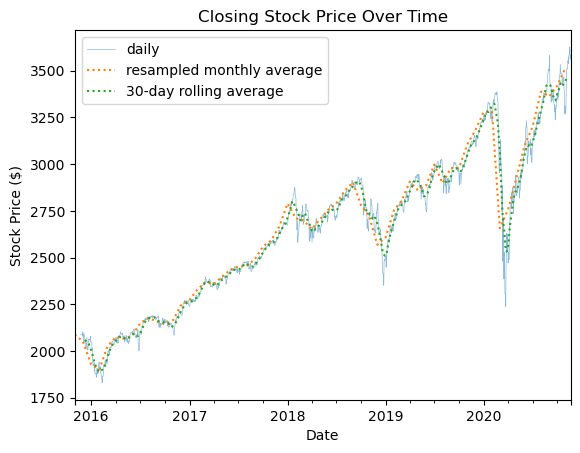

In [224]:
# Plot the closing data and resample on Monthly Frequency
ax = df['Close'].plot(alpha=0.5, style="-", linewidth=0.5)
resample = df['Close'].resample(
    'M').mean().plot(ax=ax, style=":")
rolling = df['Close'].rolling(30, center=True).mean().plot(style=':')
plt.title("Closing Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend(['daily', 'resampled monthly average', '30-day rolling average'])
plt.show()

Here we zoomed in on a 6 month segment to better visualize the data. We can see that the data that has been resampled on a monthly basis is indexed on the last day of the month but plotted on the first day of the month and therefore the trends appear to be offset from the actual data. With the rolling average, we can see that there is no trendline for the first and last 15 days.

For the purposes of evaluating stock prices, a rolling average is most representative of the data.


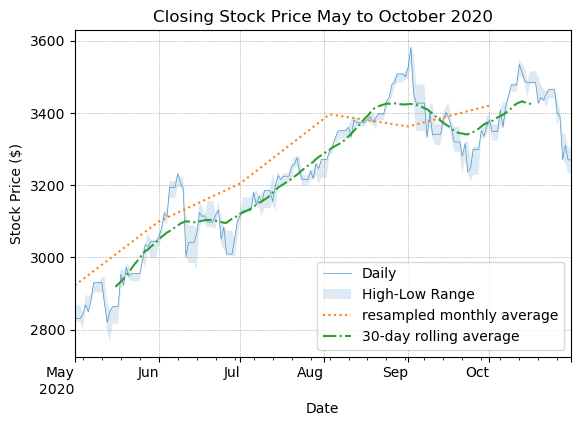

In [232]:
# zoom in to look at the last full 6 months of data
start = pd.to_datetime('2020-05-01')
end = pd.to_datetime('2020-10-31')

df_6months = df.loc[start:end]

# Background
ax = df_6months['Close'].plot(alpha=0.75, style="-", linewidth=0.5)
ax.fill_between(df_6months.index, df_6months['High'], df_6months['Low'],
                alpha=0.15, label='High-Low Range')

# Plot the monthly average on the same axes
resample_6mo = df_6months['Close'].resample('BMS').mean().plot(
    ax=ax, style=":", label='Monthly Average')

# Plot the rolling 30-day average
rolling_6mo = df_6months['Close'].rolling(30, center=True).mean().plot(
    ax=ax, style='-.', label='30-Day Rolling Mean')

plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.title("Closing Stock Price May to October 2020")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend(['Daily', 'High-Low Range',
           'resampled monthly average', '30-day rolling average'])
plt.show()

In [226]:
# View resampled mean data (end of month dates)
df_6months['Close'].resample('BMS').mean()

Date
2020-05-01    2922.437405
2020-06-01    3099.553353
2020-07-01    3204.566369
2020-08-03    3396.017603
2020-09-01    3362.484326
2020-10-01    3420.350948
Freq: BMS, Name: Close, dtype: float64

## Lag


In [227]:
close = df["Close"]
lagged_df = pd.concat(
    [
        close,
        close.shift(1).rename("lagged_close_1d"),
        close.shift(2).rename("lagged_close_2d"),
        close.shift(3).rename("lagged_close_3d"),
        close.shift(7).rename("lagged_close_1w"),
        close.shift(7 + 1).rename("lagged_close_1w_1d"),
        close.shift(30).rename("lagged_close_1m"),
        close.shift(30 + 1).rename("lagged_close_1m_1d"),
        close.shift(1).rolling(7).mean().rename("lagged_mean_7d"),
        close.shift(1).rolling(7).max().rename("lagged_max_7d"),
        close.shift(1).rolling(7).min().rename("lagged_min_7d"),
        close.shift(1).rolling(30).mean().rename("lagged_mean_30d"),
        close.shift(1).rolling(30).max().rename("lagged_max_30d"),
        close.shift(1).rolling(30).min().rename("lagged_min_30d"),
    ],
    axis="columns",
)

In [228]:
lagged_df = lagged_df.dropna()
X = lagged_df.drop('Close', axis='columns')
y = lagged_df['Close']
print("X shape: {}\ny shape: {}".format(X.shape, y.shape))

X shape: (1794, 13)
y shape: (1794,)


In [263]:
ts_cv = TimeSeriesSplit(n_splits=3)
model = Ridge()

split_ratio = 0.8
split_idx = int(split_ratio * len(X))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Print scores
print(
    f"Cross Validation Score: {cross_val_score(model, X, y, cv=ts_cv).mean():.3f}")
print(f'R2: {r2_score(y_test, y_pred):.3f}')
print(f'MAPE: { mean_absolute_percentage_error(y_test, y_pred):.3f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')

Cross Validation Score: 0.974
R2: 0.966
MAPE: 0.010
RMSE: 51.008


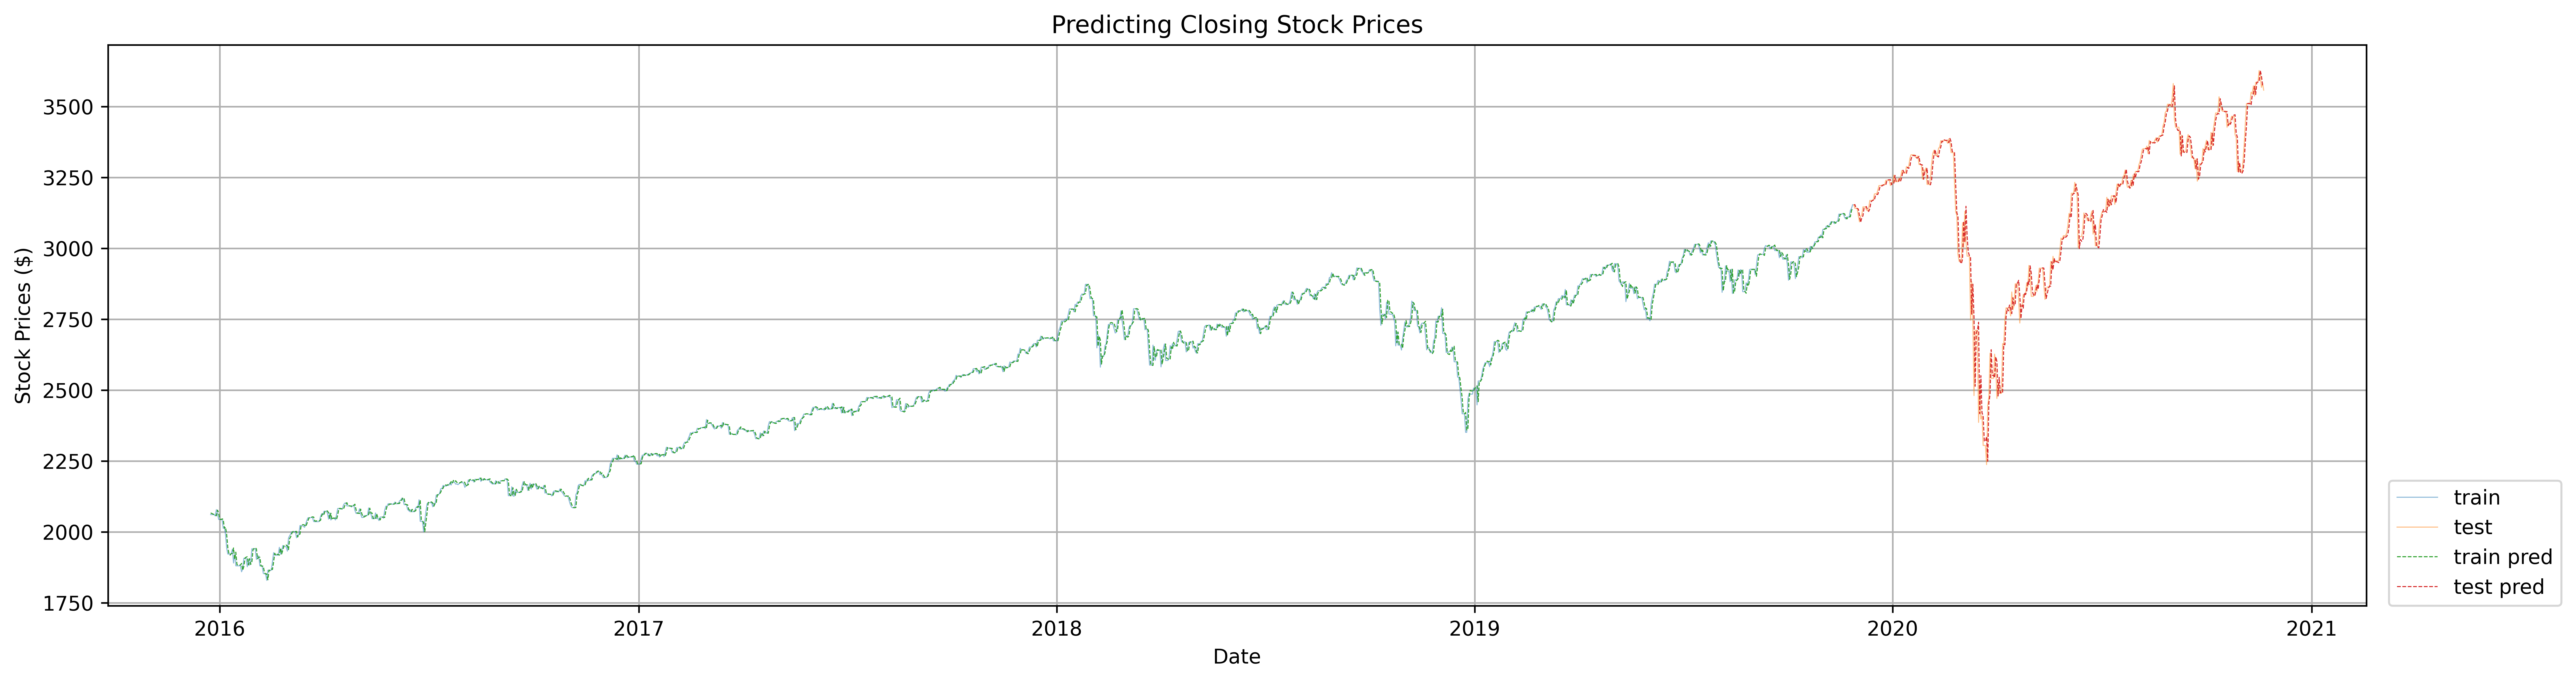

In [281]:
pd_range = pd.date_range(start=X.index.min(), end=X.index.max(), freq='D')

n_train, n_test = len(y_train), len(y_test)

plt.figure(figsize=(20, 5), dpi=600)

# Plot the data
plt.plot(pd_range[:n_train], y_train, label="train", linewidth=0.5, alpha=0.5)
plt.plot(pd_range[n_train:n_train + n_test],
         y_test, '-', label="test", linewidth=0.5, alpha=0.5)

plt.plot(pd_range[:n_train], y_train_pred, '--',
         label="train pred", linewidth=0.5)
plt.plot(pd_range[n_train:n_train + n_test], y_pred,
         '--', label="test pred", linewidth=0.5)

plt.legend(loc=(1.01, 0))
plt.xlabel('Date')
plt.ylabel("Stock Prices ($)")
plt.title("Predicting Closing Stock Prices")
plt.grid()
plt.show()